In [1]:
import cv2
import matplotlib.pyplot as plt
import torch

import data.util as data_util
import utils.util as util
from models.archs.FourLLIE import FourLLIE


def test_fourllie(model_path, input_path, GT_path, output_path, output_enhanced_path, have_GT=True):
    # 创建模型
    model = FourLLIE(nf=32)

    # 加载模型权重
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint)
    model.eval()

    # 读入暗光图片
    input_path = [input_path]
    input_img = data_util.read_img_seq(input_path)

    # 读入真实图片
    if have_GT:
        img_GT = cv2.imread(GT_path)

    # 前向
    with torch.no_grad():
        FourLLIE_img, _, _, _ = model(input_img)

    # 将结果保存到指定路径
    FourLLIE_img = util.tensor2img(FourLLIE_img)
    cv2.imwrite(output_path, FourLLIE_img)
    print(f"FourLLIE enhanced image saved at: {output_path}")

    if have_GT:
        psnr = util.calculate_psnr(FourLLIE_img, img_GT)
        ssim = util.calculate_ssim(FourLLIE_img, img_GT)
        print(f"PSNR: {psnr}, SSIM: {ssim}")

    # 转换图像为 Lab 颜色空间，拆分为 L A B 通道
    lab = cv2.cvtColor(FourLLIE_img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # 应用直方图均衡化到 L 通道
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    # 合并 L 通道与 A、B 通道
    enhanced_lab = cv2.merge([cl, a, b])

    # 将增强后的 Lab 图像转换回 BGR 颜色空间
    enhanced_img = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

    # 保存增强后的图像
    cv2.imwrite(output_enhanced_path, enhanced_img)
    print(f"CLAHE enhanced image saved at: {output_enhanced_path}")

    if have_GT:
        psnr = util.calculate_psnr(enhanced_img, img_GT)
        ssim = util.calculate_ssim(enhanced_img, img_GT)
        print(f"PSNR: {psnr}, SSIM: {ssim}")

    # 显示原始图像和增强后的图像
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(input_img.squeeze(0).permute(1, 2, 0))
    plt.title('Original Image')
    plt.axis('off')

    if have_GT:
        plt.subplot(2, 2, 2)
        plt.imshow(cv2.cvtColor(img_GT, cv2.COLOR_BGR2RGB))
        plt.title('GT Image')
        plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(cv2.cvtColor(FourLLIE_img, cv2.COLOR_BGR2RGB))
    plt.title('FourLLIE Image')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2RGB))
    plt.title('CLAHE Enhanced Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

d:\anaconda3\envs\DIP\lib\site-packages\torch\nn\functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


FourLLIE enhanced image saved at: ./2062_FourLLIE.jpg
PSNR: 22.681174468877675, SSIM: 0.7311805845220937
CLAHE enhanced image saved at: ./2062_Lab_CLAHE.jpg
PSNR: 20.20494311780777, SSIM: 0.6958698142546044


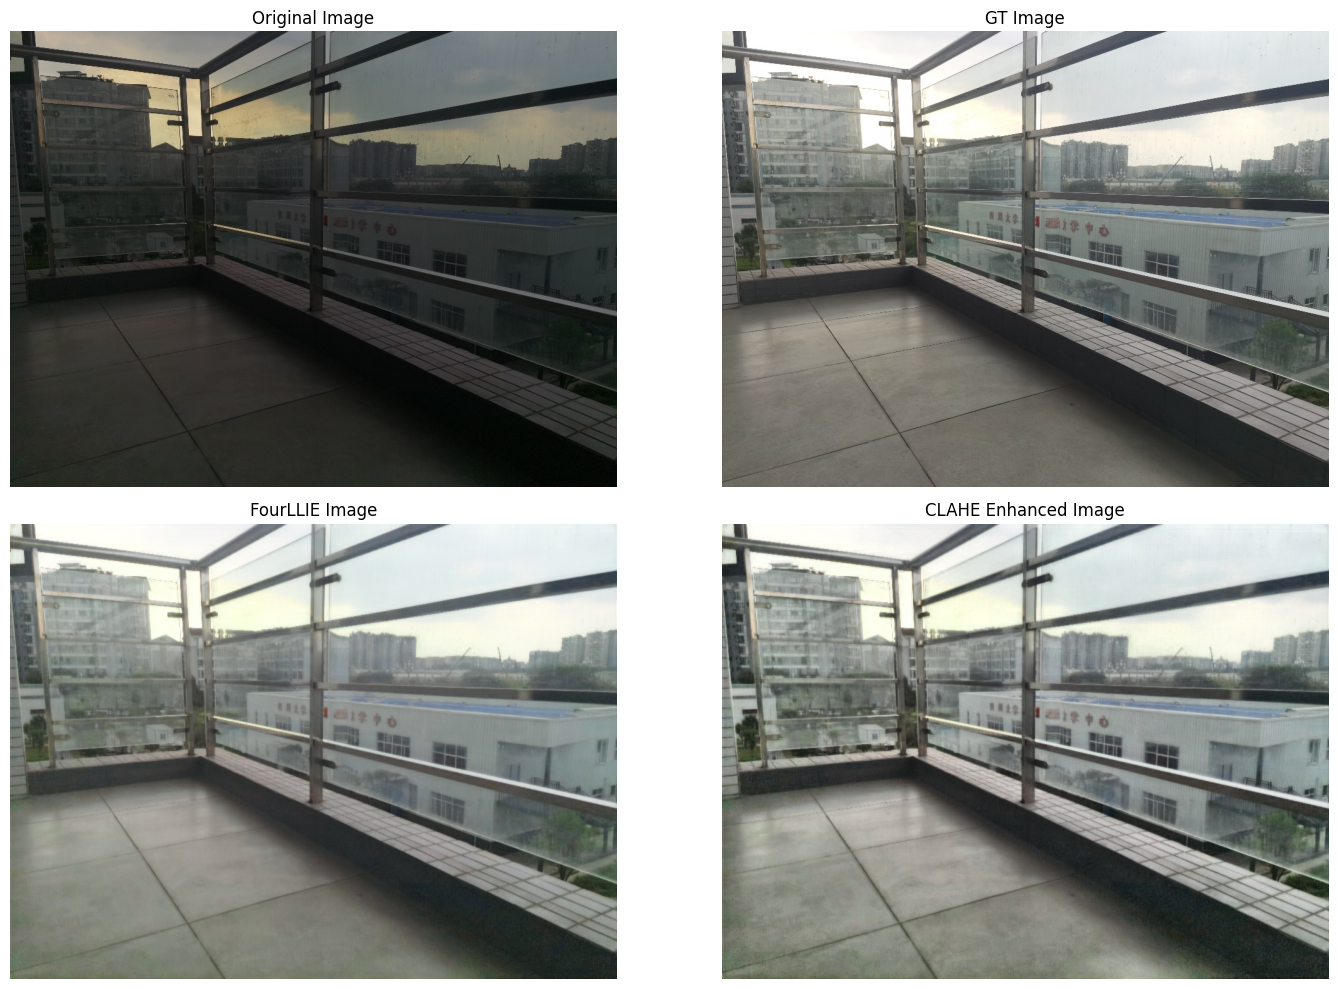

In [2]:
model_path = "./experiments/train/models/56000_G.pth"
dataset = "Huawei"
name = "2062"

input_path = f"./Eval/{dataset}/low/{name}.jpg"
GT_path = f"./Eval/{dataset}/high/{name}.jpg"
output_path = f"./{name}_FourLLIE.jpg"
output_enhanced_path = f"./{name}_Lab_CLAHE.jpg"

test_fourllie(model_path, input_path, GT_path, output_path, output_enhanced_path, have_GT=True)